# Display Some Images

In [1]:
import os
# import shutil
# import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

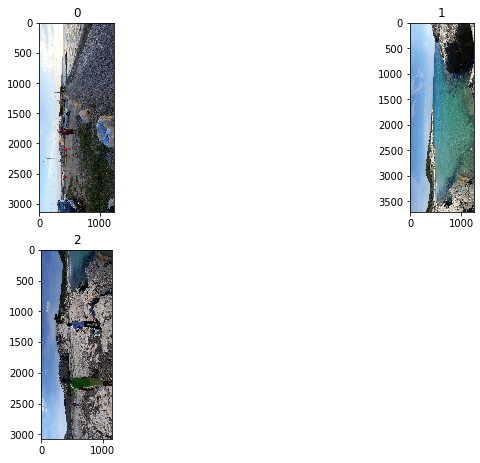

In [2]:
# One folder with all images to sort :
# “One Folder to rule them all, One Folder to find them, 
# One Folder to bring them all and in the darkness classify them.”  
src_folder = "C:\data\class_unsup\poc2"

def plot_some_images(src_folder, max_images=5, figsize=(12, 16)):
    # Set up a figure of an appropriate size
    fig = plt.figure(figsize=(12, 16))
    
    img_num = 0

    # loop through the images
    filenames = os.listdir(src_folder)
    for file in filenames:
        
        imgFile = os.path.join(src_folder, file)
        img = Image.open(imgFile)
        # Add the image to the figure (which will have 4 rows and enough columns to show a file from each folder)
        a=fig.add_subplot(4,2,img_num + 1)
        
        imgplot = plt.imshow(img)
        # Add a caption with the folder name
        a.set_title(img_num)
        img_num = img_num + 1  
        if img_num == max_images : break
    
plot_some_images(src_folder, max_images=3, figsize=(12, 16))

# Classification

Following [beleidy/unsupervised-image-clustering](https://github.com/beleidy/unsupervised-image-clustering/blob/master/capstone.ipynb) capstone project, we will infer 3 different models to our images to ge the features present in our images. We then use PCA for dimension reduction purposes and finally we implement a clustering algorithm to make clusters of images by similarity.

## Preprocess and Normalize Images

In [3]:
import numpy as np

In [4]:
def resize_image(src_image, size=(128,128), bg_color="white"): 
    from PIL import Image, ImageOps 
    
    # resize the image so the longest dimension matches our target size
    src_image.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new square background image
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the resized image into the center of the square background
    new_image.paste(src_image, (int((size[0] - src_image.size[0]) / 2), int((size[1] - src_image.size[1]) / 2)))
  
    # return the resized image
    return new_image

In [5]:
def load_images(src_folder, size=(128,128)):
    
    # loop through the images
    # Load .jpg only
    filenames = [jpg for jpg in os.listdir(src_folder) if jpg.endswith(".jpg")]
    
    # Define empty arrays where we will store our images and labels
    images = []
            
    for file in filenames:
        imgFile = os.path.join(src_folder, file)
        # open & resize
        img = Image.open(imgFile)
        img = resize_image(img, size, bg_color="white")
        
        # Convert to numpy arrays
        img = np.array(img, dtype=np.float32)

        # Normalise the images
        img /= 255
        
        # Now we add it to our array
        images.append(img)

    return np.array(images, dtype=np.float32)

In [6]:
images = load_images(src_folder)

# Load Model and Make Predictions On Images

## Load Models

In [27]:
import keras
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import time


In [9]:
input_shape=(128,128,3)

resnet50_model = keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=input_shape)
vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=input_shape)
vgg19_model = keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=input_shape)

In [10]:
def flatten_output(covnet_model, raw_images):
    # Infer the model on raw data
    pred = covnet_model.predict(raw_images)
    # Flatten the prediction array
    flat = pred.reshape(raw_images.shape[0], -1)
    
    return flat

In [11]:
resnet50_output = flatten_output(resnet50_model, images)
print("ResNet50 flattened output has {} features".format(resnet50_output.shape[1]))

vgg16_output = flatten_output(vgg16_model, images)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

vgg19_output = flatten_output(vgg19_model, images)
print("VGG19 flattened output has {} features".format(vgg19_output.shape[1]))

ResNet50 flattened output has 32768 features
VGG16 flattened output has 8192 features
VGG19 flattened output has 8192 features


## PCA Implementation

In [12]:
# Function that creates a PCA instance, fits it to the data and returns the instance
def create_fit_PCA(data, n_components=None):
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    return p

# Function to plot the cumulative explained variance of PCA components
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

In [17]:
# Create PCA instances for each covnet output
vgg16_pca = create_fit_PCA(vgg16_output)
vgg19_pca = create_fit_PCA(vgg19_output)
resnet50_pca = create_fit_PCA(resnet50_output)

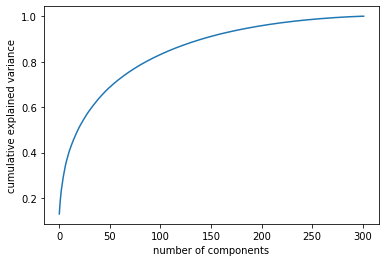

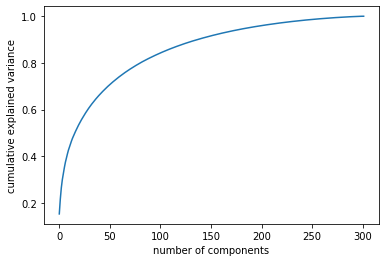

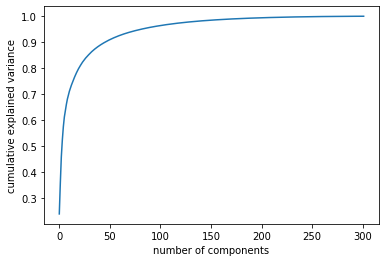

In [18]:
# Plot the cumulative explained variance for each covnet
pca_cumsum_plot(vgg16_pca)
pca_cumsum_plot(vgg19_pca)
pca_cumsum_plot(resnet50_pca)

In [19]:
vgg16_output_pca = vgg16_pca.transform(vgg16_output)
vgg19_output_pca = vgg19_pca.transform(vgg19_output)
resnet50_output_pca = resnet50_pca.transform(resnet50_output)

## Clustering Algorithms

In [22]:
nb_clusters = 5

# KMEANS
def create_train_kmeans(data, number_of_clusters=nb_clusters):
    
    k = KMeans(n_clusters=number_of_clusters, random_state=728)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [25]:
# GAUSSIAN MIXTURE
def create_train_gmm(data, number_of_clusters=nb_clusters):
    g = GaussianMixture(n_components=number_of_clusters, covariance_type="full", random_state=728)
    
    start=time.time()
    g.fit(data)
    end=time.time()
    
    print("Training took {} seconds".format(end-start))
    
    return g

In [30]:
print("\n FIT DATA \n")

# Here we create and fit a KMeans model with the PCA outputs
print("\n KMeans (PCA): \n")

K_vgg16_pca = create_train_kmeans(vgg16_output_pca)
K_vgg19_pca = create_train_kmeans(vgg19_output_pca)
K_resnet50_pca = create_train_kmeans(resnet50_output_pca)

# Same for Gaussian Model
print("\n GMM (PCA): \n")

G_vgg16_pca = create_train_gmm(vgg16_output_pca)
G_vgg19_pca = create_train_gmm(vgg19_output_pca)
G_resnet50_pca = create_train_gmm(resnet50_output_pca)

# Let's also create models for the covnet outputs without PCA for comparison
print("\n KMeans: \n")

K_vgg16 = create_train_kmeans(vgg16_output)
K_vgg19 = create_train_kmeans(vgg19_output)
K_resnet50 = create_train_kmeans(resnet50_output)


 FIT DATA 


 KMeans (PCA): 

Training took 0.4700033664703369 seconds
Training took 0.43306970596313477 seconds
Training took 0.4118161201477051 seconds

 GMM (PCA): 

Training took 0.33155393600463867 seconds
Training took 0.35921812057495117 seconds
Training took 0.34180188179016113 seconds

 KMeans: 

Training took 5.31255578994751 seconds
Training took 5.06139612197876 seconds
Training took 20.365934371948242 seconds


In [31]:
# PREDICTIONS
print("\n GENERATE CLUSTER DATA \n")

# KMeans with PCA outputs
k_vgg16_pred_pca = K_vgg16_pca.predict(vgg16_output_pca)
k_vgg19_pred_pca = K_vgg19_pca.predict(vgg19_output_pca)
k_resnet50_pred_pca = K_resnet50_pca.predict(resnet50_output_pca)

# KMeans with CovNet outputs
k_vgg16_pred = K_vgg16.predict(vgg16_output)
k_vgg19_pred = K_vgg19.predict(vgg19_output)
k_resnet50_pred = K_resnet50.predict(resnet50_output)

# Gaussian Mixture with PCA outputs
g_resnet50_pred_pca = G_resnet50_pca.predict(resnet50_output_pca)
g_vgg16_pred_pca = G_vgg16_pca.predict(vgg16_output_pca)
g_vgg19_pred_pca = G_vgg19_pca.predict(vgg19_output_pca)


 GENERATE CLUSTER DATA 



In [32]:
def reference_labels (nb_clusters):
    labels = []
    dico = {}
    for i in range(nb_clusters):
        dico[i] = []
    return dico

In [34]:
def group_and_plot(src_folder, clusters, size=(128,128), plot=True):
    
    dico = reference_labels(nb_clusters)
    
    filenames = [jpg for jpg in os.listdir(src_folder) if jpg.endswith(".jpg")]
            
    for i, clu in enumerate(clusters):
        dico[clu].append(filenames[i])
        
    if plot :
        
        for clu in dico.keys():
            
            print("************************************************")
            print(f"****************** group {clu} *******************")
            print("************************************************")
            
            n_col = 4
            n_row = (len(dico[clu]) // n_col) + 1
            plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
            fig = plt.figure(figsize=(n_col*3 , n_row*3 ))
            
            for i, file in enumerate(dico[clu]):
                imgFile = os.path.join(src_folder, file)
                img = Image.open(imgFile)
                img = resize_image(img, size, bg_color="black")
                
                plt.subplot(n_row, n_col, i + 1)
                plt.imshow(img)

            plt.show()
                
    return dico

************************************************
****************** group 0 *******************
************************************************


<Figure size 432x288 with 0 Axes>

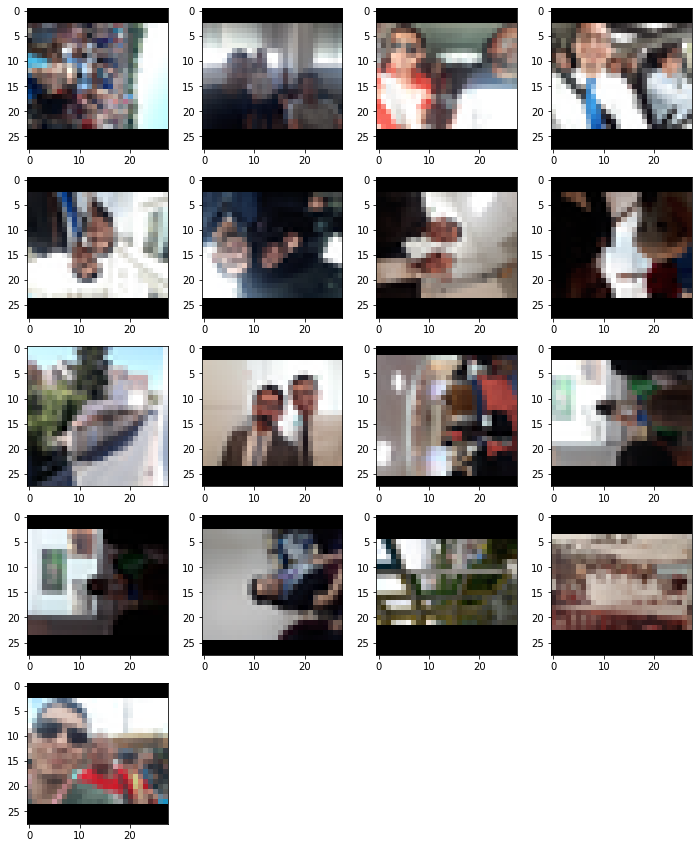

************************************************
****************** group 1 *******************
************************************************


<Figure size 432x288 with 0 Axes>

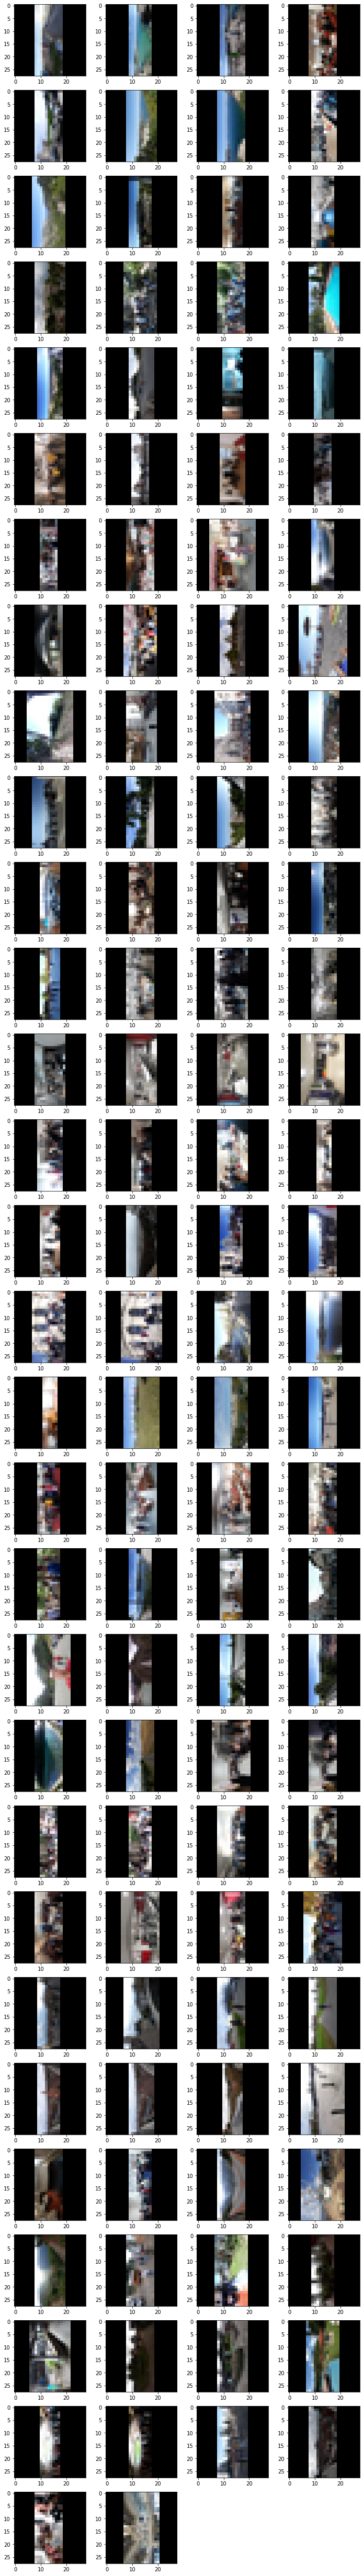

************************************************
****************** group 2 *******************
************************************************


<Figure size 432x288 with 0 Axes>

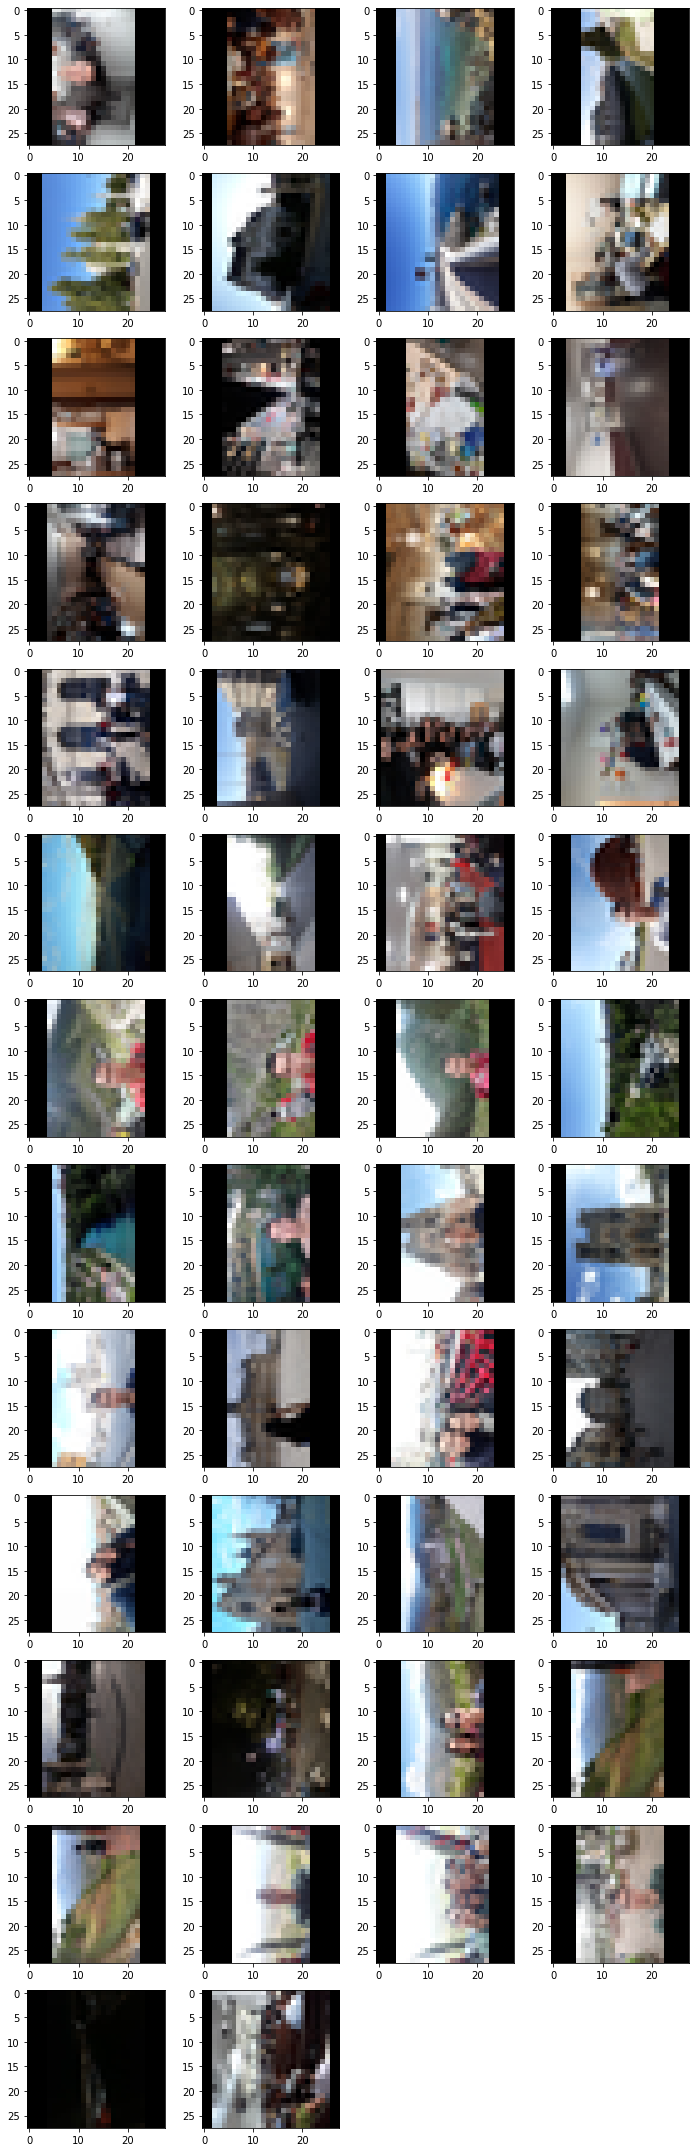

************************************************
****************** group 3 *******************
************************************************


<Figure size 432x288 with 0 Axes>

In [ ]:
g_resnet50_pred_pca_sorted_filenames = group_and_plot(src_folder, g_resnet50_pred_pca, size=(28,28), plot=True)